# Purpose


We would like to measure the Table of Content usage on English Wikipedia after the Vector 2022 skin deployment.

We expect ToC usage will increase.

Analysis ticket: https://phabricator.wikimedia.org/T329234

Data issue: https://phabricator.wikimedia.org/T329333

Fix ticket: https://phabricator.wikimedia.org/T332612



In [2]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
library(tidyverse); 
library(lubridate); 
library(scales);
library(magrittr); 
library(dplyr);
})

In [5]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [6]:
options(repr.plot.width = 15, repr.plot.height = 10)

# Instrumentation Note
## Old Table of Contents


<img src="Figures/old.png" width="800" height="600" align="center"/>

## New Table of Contents
### Clicks on ToC
ToC on left sidebar ,logged with `event.name='ui.sidebar-toc'` <br />
Scenario 1: ToC with sticky header <br />
<img src="Figures/toc_new1.png" width="800" height="600" align="center"/>
<br />
<br />
<br />
Scenario 2: ToC at top when main menu is hiden <br />
<img src="Figures/toc_new2.png" width="800" height="600" align="center"/>
<br />
<br />
<br />


ToC by page title, logged with `event.name='toc-{{section ID}}.vector-toc.unpinned'`. Some clicks have been logged with `event.name='toc-{{section ID}}.unknown.unpinned'` since 2023-03-16 (bug). Some clicks in old browser with cache created in Dec 2022 were logged as `event.name='toc-{{section ID}}`. The events are very few as of Apr. 2023, can be excluded in analysis. <br />
Scenario 1: ToC by page title at top <br />
<img src="Figures/toc_new3.png" width="800" height="600" align="center"/>
<br />
<br />
<br />
Scenario 2: ToC by page title with sticky header <br />
<img src="Figures/toc_new4.png" width="800" height="600" align="center"/>
<br />
<br />
<br />

ToC at narrow widths when the ToC is pinned to the left sidebar, logged with `event.name='toc-{{section ID}}.vector-toc.pinned'` or `event.name='toc-{{section ID}}.unknown.pinned'`(bug)
<img src="Figures/toc_new6_narrow.png" width="400" height="300" align="center"/>

### Pin/unpin
Pin is logged with `event.name='pinnable-header.vector-toc.pin'` <br />
Scenario 1: Pin the ToC at top to sidebar: 
<img src="Figures/toc_to_pin1.png" width="800" height="600" align="center"/>
Scenario 2: Pin the ToC with sticky header to sidebar: 
<img src="Figures/toc_to_pin2.png" width="800" height="600" align="center"/>
<br />
<br />
<br />
Unpin is logged with `event.name='pinnable-header.vector-toc.unpin'` <br />
<img src="Figures/toc_to_unpin.png" width="800" height="600" align="center"/>
<br />
<br />
<br />

### Clicks on dropdown menu
Click on dropdown at top, logged with `event.name='ui.dropdown-vector-page-titlebar-toc'` <br />
<img src="Figures/toc_dropdown1.png" width="800" height="600" align="center"/>
<br />
<br />
<br />
Click on dropdown with sticky header, logged with `event.name='ui.dropdown-vector-sticky-header-toc'` <br />
<img src="Figures/toc_dropdown2.png" width="800" height="600" align="center"/>

# Data exploration

## Explore request_id, token, pagetoken in schema

In [4]:
query <- "
SELECT event.isAnon,event.skin, count(distinct event.pageToken) AS pages,
COUNT(DISTINCT meta.id) as meta_ids, 
COUNT(DISTINCT meta.request_id) as meta_request_ids, 
count(DISTINCT event.token) AS event_tokes,
count(1) clicks
FROM event.DesktopWebUIActionsTracking
WHERE wiki='enwiki'
AND year=2023 and month=1
AND event.action='click' 
AND event.name IN  ('ui.sidebar-toc') 
GROUP BY event.isAnon,event.skin
"

In [5]:
df <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [6]:
df

isanon,skin,pages,meta_ids,meta_request_ids,event_tokes,clicks
<chr>,<chr>,<int>,<int>,<int>,<int>,<int>
false,vector-2022,490174,825712,825712,145574,825712
true,vector-2022,308243,490619,490619,295643,490619


__Note:__

event.token is close to a session token    
meta.id, and meta.request_id create every clicks

## Do we have data of clicking on legacy toc as the pre-deployment baseline?

The clicks on legacy toc (event.name='ui.toc') were not tracked since Jan 2023. (https://phabricator.wikimedia.org/T329333) Can we use the last year data as the baseline, at least for logged-in usrs?

In [15]:
query_test_2022<- "
SELECT event.isAnon, event.skinVersion, event.name, count(1) AS clicks
FROM event_sanitized.DesktopWebUIActionsTracking
WHERE wiki='enwiki'
AND year=2022 
AND event.action='click' 
AND event.name IN ('ui.toc', 'ui.sidebar-toc')
GROUP BY event.isAnon, event.skinVersion, event.name
"

In [16]:
df_test_2022 <- wmfdata::query_hive(query_test_2022)

Don't forget to authenticate with Kerberos using kinit



In [18]:
df_test_2022

isanon,skinversion,name,clicks
<chr>,<int>,<chr>,<int>
false,2,ui.sidebar-toc,1363887
true,2,ui.sidebar-toc,2
false,2,ui.toc,69329


Note:  
We logged clicks on toc on logged-in users in 2022 with event.name='ui.toc' for legacy toc during AB test, event.name='ui.sidebar-toc' for new toc during. 



In [19]:
query_2022_daily <- "
SELECT TO_DATE(dt) AS event_date, event.skinVersion, event.name, count(1) AS clicks
FROM event_sanitized.DesktopWebUIActionsTracking
WHERE wiki='enwiki'
AND year=2022 
AND event.action='click' 
AND event.name IN ('ui.toc', 'ui.sidebar-toc')
GROUP BY TO_DATE(dt), event.skinVersion, event.name
"

In [20]:
df_2022_daily <- wmfdata::query_hive(query_2022_daily)

Don't forget to authenticate with Kerberos using kinit



In [21]:
df_2022_daily$event_date <- as.Date(df_2022_daily$event_date)

In [31]:
df_2022_daily %>%
  arrange(event_date) %>% 
    tail(30)

,event_date,skinversion,name,clicks
,<date>,<int>,<chr>,<int>
493,2022-12-09,2,ui.toc,42
494,2022-12-09,2,ui.sidebar-toc,7954
495,2022-12-10,2,ui.sidebar-toc,8007
496,2022-12-10,2,ui.toc,57
497,2022-12-11,2,ui.sidebar-toc,8131
498,2022-12-11,2,ui.toc,41
499,2022-12-12,2,ui.toc,49
500,2022-12-12,2,ui.sidebar-toc,9378
501,2022-12-13,2,ui.toc,56


In [33]:
df_2022_daily %>%
  arrange(event_date) %>% 
    head(5)

,event_date,skinversion,name,clicks
,<date>,<int>,<chr>,<int>
1,2022-03-31,2,ui.toc,1616
2,2022-04-01,2,ui.sidebar-toc,3
3,2022-04-01,2,ui.toc,2218
4,2022-04-02,2,ui.toc,1609
5,2022-04-03,2,ui.toc,2087


In [34]:
df_2022_daily  %>%
   filter(skinversion==1)

event_date,skinversion,name,clicks
<date>,<int>,<chr>,<int>


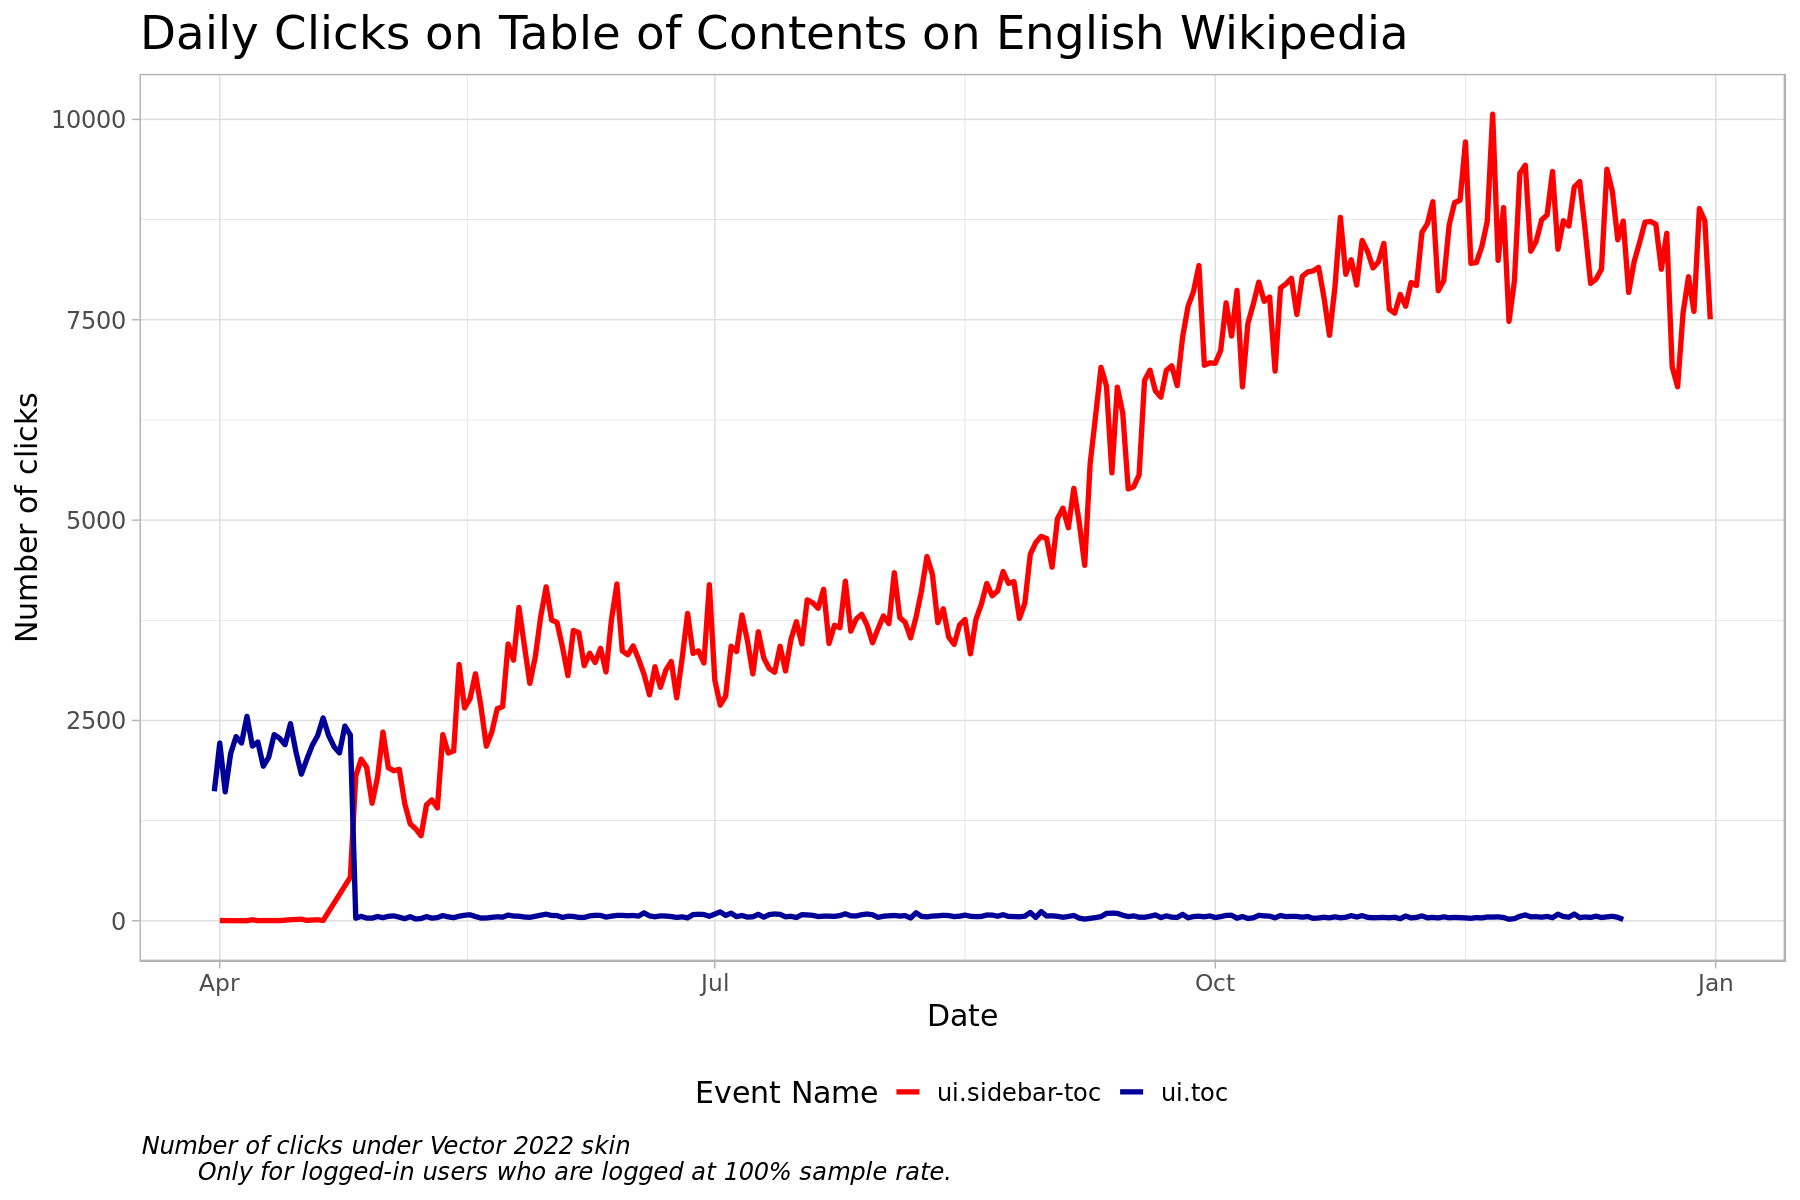

In [28]:
toc_click_2022_g <- df_2022_daily  %>%
   filter(skinversion==2) %>%
   ggplot(mapping=aes(x=event_date, y=clicks, color=name)) +
   geom_line( size = 1.5) +
  scale_color_manual(values= c("#FF0000", "#000099"), name = "Event Name")  +
  labs(title = 'Daily Clicks on Table of Contents on English Wikipedia',
     x = 'Date',
     y = 'Number of clicks',
     caption = "Number of clicks under Vector 2022 skin
       Only for logged-in users who are logged at 100% sample rate.") +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
toc_click_2022_g



Note:

Clicks shown in above graph only counts the logged-in users in Vector 2022. Clicks from loggedin users in Vector skin is not logged. 



## Conclusion
Unfortunately, we could not find the data for pre-deployment as the baseline as we did not track vector skin in 2022.  We only tracked clicks on legacy toc in vector-2022 skin between 2022-03-31 and 2022-12-15.

# Daily trend



In [27]:
query_event_name <- "
SELECT DISTINCT event.name
FROM event.DesktopWebUIActionsTracking
WHERE wiki='enwiki'
AND year=2023 and month IN (1,2,3)
AND event.action='click' 
AND ( event.name regexp '^toc' OR event.name='ui.sidebar-toc')
AND NOT event.isAnon
AND event.skin='vector-2022'
" 

In [28]:
df_event_name <- wmfdata::query_hive(query_event_name)

Don't forget to authenticate with Kerberos using kinit



In [50]:
df_event_name

name
<chr>
toc-Additional_awards_and_honors.vector-toc.pinned
toc-Battles.vector-toc.pinned
toc-Breathe_Carolina_version.vector-toc.pinned
toc-CLA_180_BlueEFFICIENCY_Edition_(2013–2019).vector-toc.pinned
toc-Candidate_countries
toc-Distribution.unknown.pinned
toc-Dodos_transported_abroad.vector-toc.pinned
toc-Earls_of_Selkirk_(1646).vector-toc.pinned
toc-FL5_(2022;_based_on_eleventh_generation_Civic).vector-toc.pinned


In [41]:
query_daily <- "
SELECT TO_DATE(meta.dt) AS event_date,
count(distinct event.pageToken) AS pages,
count(DISTINCT event.token) AS event_tokes,
count(1) clicks
FROM event.DesktopWebUIActionsTracking
WHERE wiki='enwiki'
AND year=2023 and month IN (1,2,3)
AND event.action='click' 
AND ( event.name regexp '^toc' OR event.name='ui.sidebar-toc')
AND NOT event.isAnon
AND event.skin='vector-2022'
GROUP BY TO_DATE(meta.dt)
ORDER BY event_date
LIMIT 100000
"

In [42]:
df_daily <- wmfdata::query_hive(query_daily)

Don't forget to authenticate with Kerberos using kinit



In [43]:
df_daily

event_date,pages,event_tokes,clicks
<chr>,<int>,<int>,<int>
2023-01-01,4830,1311,8322
2023-01-02,4982,1491,8308
2023-01-03,5376,1592,8814
2023-01-04,5423,1568,9222
2023-01-05,4973,1591,8506
2023-01-06,5327,1599,8897
2023-01-07,5212,1490,8598
2023-01-08,5200,1505,8675
2023-01-09,5433,1675,9179


In [44]:
df_daily$event_date <- as.Date(df_daily$event_date)

In [45]:
head(df_daily)

,event_date,pages,event_tokes,clicks
,<date>,<int>,<int>,<int>
1,2023-01-01,4830,1311,8322
2,2023-01-02,4982,1491,8308
3,2023-01-03,5376,1592,8814
4,2023-01-04,5423,1568,9222
5,2023-01-05,4973,1591,8506
6,2023-01-06,5327,1599,8897


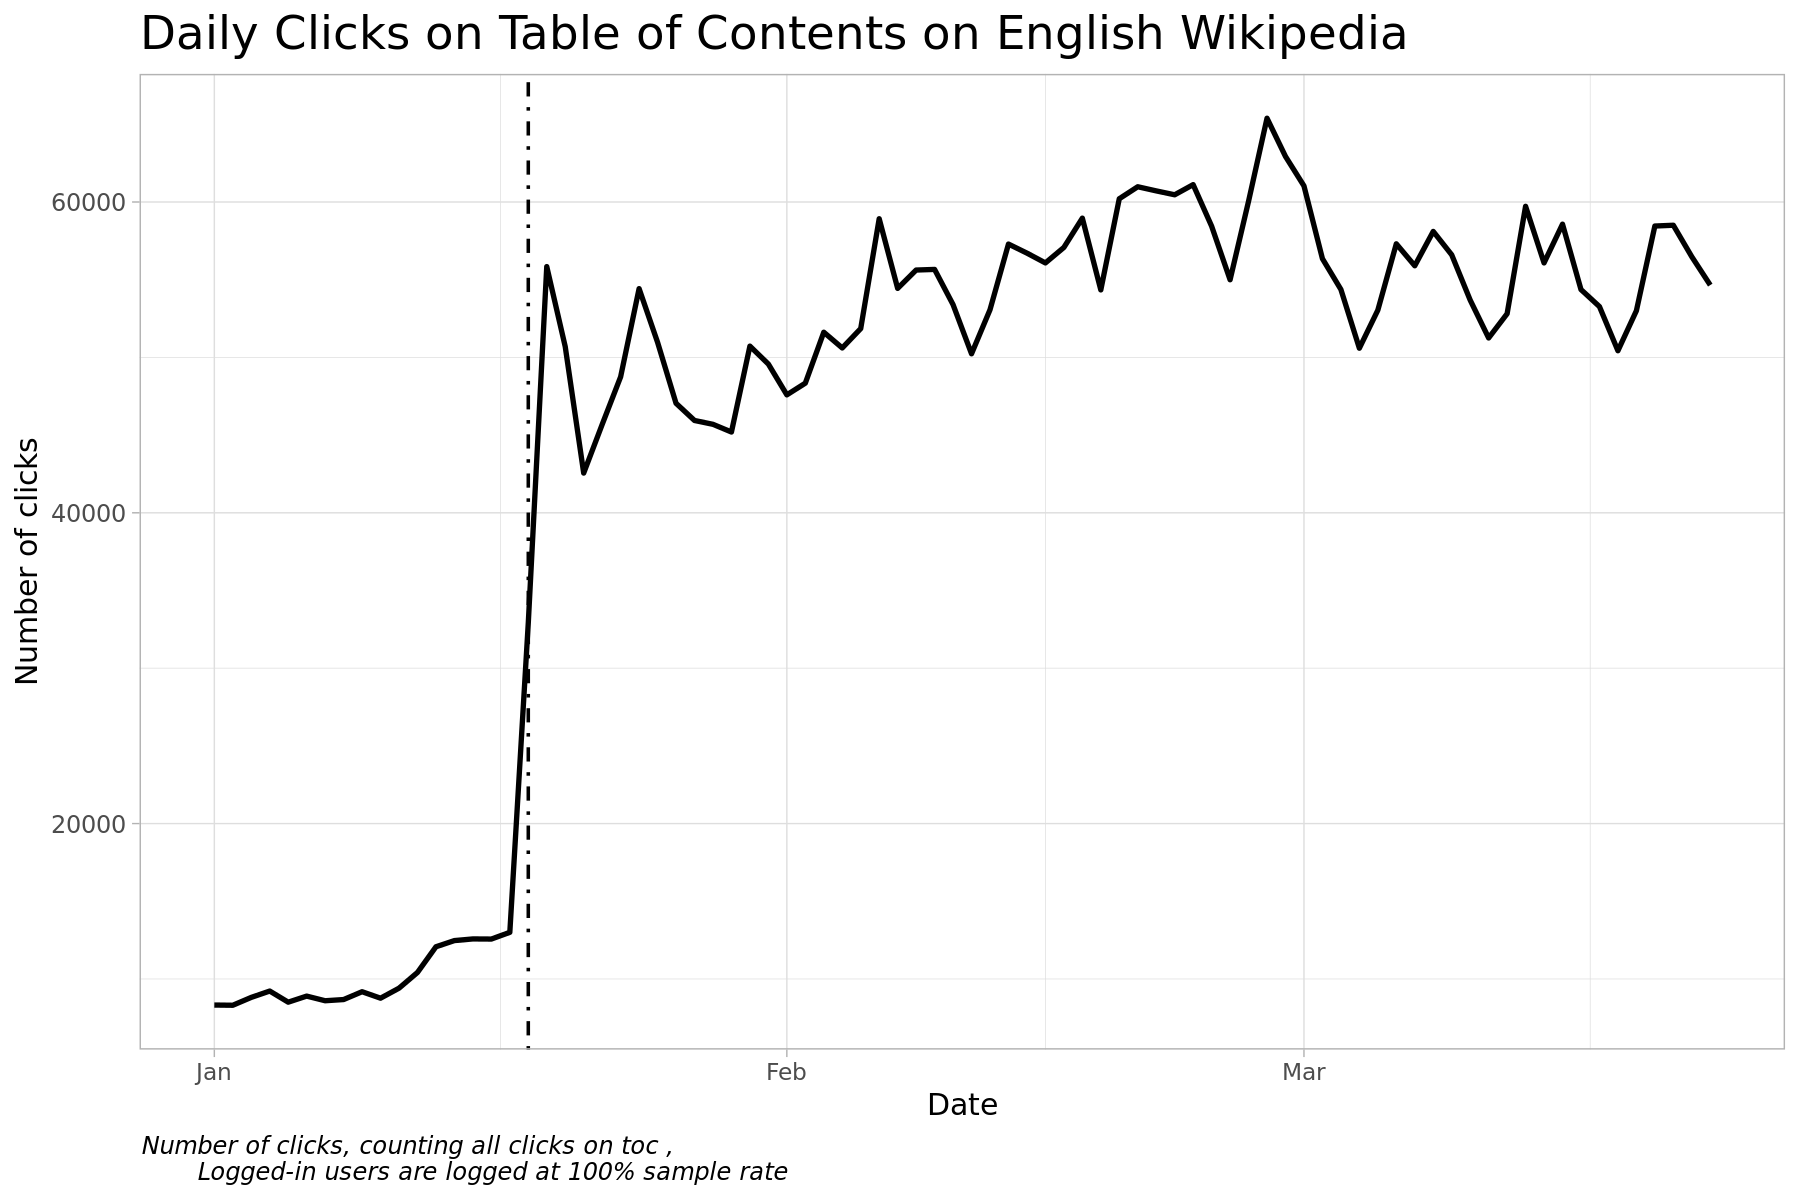

In [47]:
toc_click_g <- df_daily  %>%
   # exclude the recent incompleted day
    slice(1:(n() - 1)) %>%
   ggplot(mapping=aes(x=event_date, y=clicks)) +
   geom_line( linewidth = 1.5) +
   geom_vline(aes(xintercept = as.numeric(as.Date('2023-01-18'))), linetype="dotdash", color="black", size=1)+
  labs(title = 'Daily Clicks on Table of Contents on English Wikipedia ',
     x = 'Date',
     y = 'Number of clicks',
     caption = "Number of clicks, counting all clicks on toc , 
       Logged-in users are logged at 100% sample rate") +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
toc_click_g

# Clicks per page per session

Since we do not have a baseline to assess the impact of vector-2022 deployment on the ToC feature, our strategy is to examine the distribution of ToC clicks made by logged-in users in Vector-2022 skin on enwiki and compare it with the distribution on other wikis in the AB test results.

In [7]:
query_all <- "
SELECT event.token AS session_id, 
event.pageToken AS page_token,
count(1) clicks
FROM event.DesktopWebUIActionsTracking
WHERE wiki='enwiki'
AND year=2023 and month IN (1,2,3)
AND TO_DATE(meta.dt) BETWEEN '2023-01-19' AND '2023-03-18'
AND event.action='click' 
AND  ( event.name regexp '^toc' OR event.name='ui.sidebar-toc')
AND NOT event.isAnon
AND event.skin='vector-2022'
GROUP BY event.token, event.pageToken
"

In [8]:
df_all <- wmfdata::query_hive(query_all)

Don't forget to authenticate with Kerberos using kinit



In [9]:
summary(df_all)

  session_id         page_token            clicks       
 Length:1975342     Length:1975342     Min.   :  1.000  
 Class :character   Class :character   1st Qu.:  1.000  
 Mode  :character   Mode  :character   Median :  1.000  
                                       Mean   :  1.622  
                                       3rd Qu.:  2.000  
                                       Max.   :548.000  

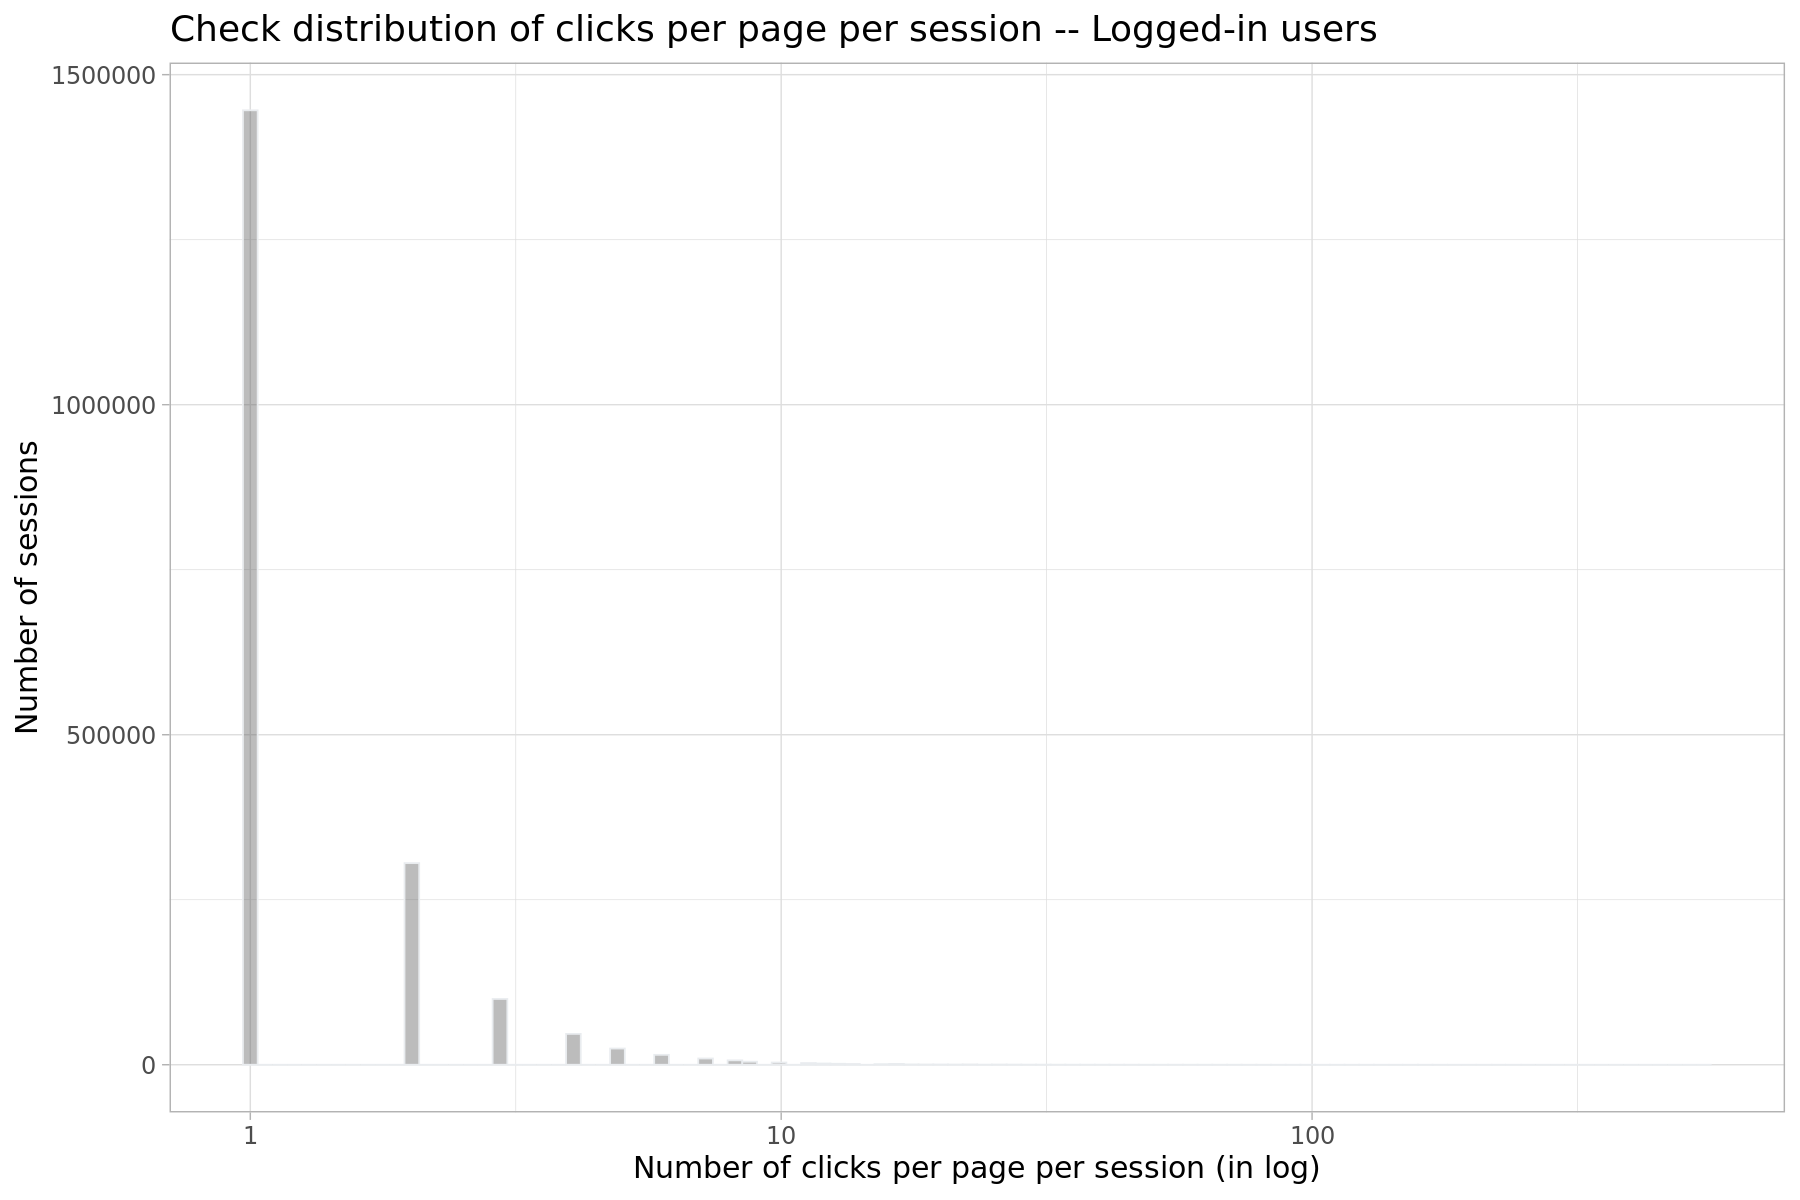

In [10]:
p1 <- df_all%>%
 ggplot( aes(x=clicks)) +
    geom_histogram( color="#e9ecef", alpha=0.4, position = 'identity', bins=100) +
    scale_x_log10() +
    labs ( title = "Check distribution of clicks per page per session -- Logged-in users",
           x = 'Number of clicks per page per session (in log)',
          y = 'Number of sessions',
         fill="") +
    theme_light(base_size=18)
p1
    

In [11]:
df_his <- df_all %>% 
  group_by(clicks) %>%
  summarize(sessions=n(), .groups='drop') 

In [12]:
df_his

clicks,sessions
<int>,<int>
1,1446056
2,305462
3,99693
4,46761
5,24570
6,15009
7,9498
8,6689
9,4613


In [13]:
total_sessions <- sum(df_his$sessions)

In [14]:
total_sessions

[1] 1975342

In [15]:
df_his <- df_his %>%
  mutate(
    proportion = round(sessions*100/total_sessions,4) 
 )
     



In [16]:
df_his %>%
 filter(clicks <16)

clicks,sessions,proportion
<int>,<int>,<dbl>
1,1446056,73.2053
2,305462,15.4638
3,99693,5.0469
4,46761,2.3672
5,24570,1.2438
6,15009,0.7598
7,9498,0.4808
8,6689,0.3386
9,4613,0.2335


## Summary
Among the page sessions which have clicked on ToC, 73.21% sessions clicked once, 15.46% sessions clicked twice. 

THe distribution is similar to the one of treatment group in AB test on polit wikis.

https://github.com/jenniferwang-wmf/WEB_table_of_contents/blob/master/analysis_5_clicks_modeling.ipynb

# Appendix

## QA `event.name='toc-{{section ID}}.vector-toc.pinned'` or `event.name='toc-{{section ID}}.unknown.pinned`

ref: https://mpopov.com/blog/2020/05/22/strings-in-r-4.x/

In [18]:
query_test <- r"(
select TO_DATE(dt) AS event_date,
CASE WHEN event.name regexp 'vector-toc' THEN 'vector-toc' 
     WHEN event.name regexp 'unknown' THEN 'unknown' 
     ELSE 'others' END AS event_name,
COUNT(1) AS clicks
FROM event.desktopwebuiactionstracking
WHERE year=2023 and month=3 
AND wiki='enwiki'
AND  ((event.name  regexp  '^toc' 
AND event.name  regexp 'vector-toc\.pinned$' ) OR
   (event.name  regexp  '^toc' 
AND event.name  regexp 'unknown\.pinned$' ) )
GROUP BY TO_DATE(dt),
CASE WHEN event.name regexp 'vector-toc' THEN 'vector-toc' 
     WHEN event.name regexp 'unknown' THEN 'unknown' 
     ELSE 'others' END 
LIMIT 1000
)"

In [20]:
df_test <- wmfdata::query_hive(query_test)

Don't forget to authenticate with Kerberos using kinit



In [23]:
df_test

event_date,event_name,clicks
<chr>,<chr>,<int>
2023-03-03,vector-toc,730
2023-03-22,vector-toc,10
2023-03-13,vector-toc,906
2023-03-24,unknown,817
2023-03-04,vector-toc,993
2023-03-23,vector-toc,5
2023-03-14,vector-toc,874
2023-03-25,unknown,801
2023-03-05,vector-toc,926


In [75]:
df_test <- read.csv("Data_query/data_out/toc_qa.csv")

In [77]:
df_test$event_date <- as.Date(df_test$event_date)

In [86]:
df_test %>%
  arrange(event_date)

event_date,event_name,clicks
<date>,<chr>,<int>
2023-03-01,vector-toc,919
2023-03-02,vector-toc,694
2023-03-03,vector-toc,730
2023-03-04,vector-toc,993
2023-03-05,vector-toc,926
2023-03-06,vector-toc,943
2023-03-07,vector-toc,1047
2023-03-08,vector-toc,884
2023-03-09,vector-toc,943


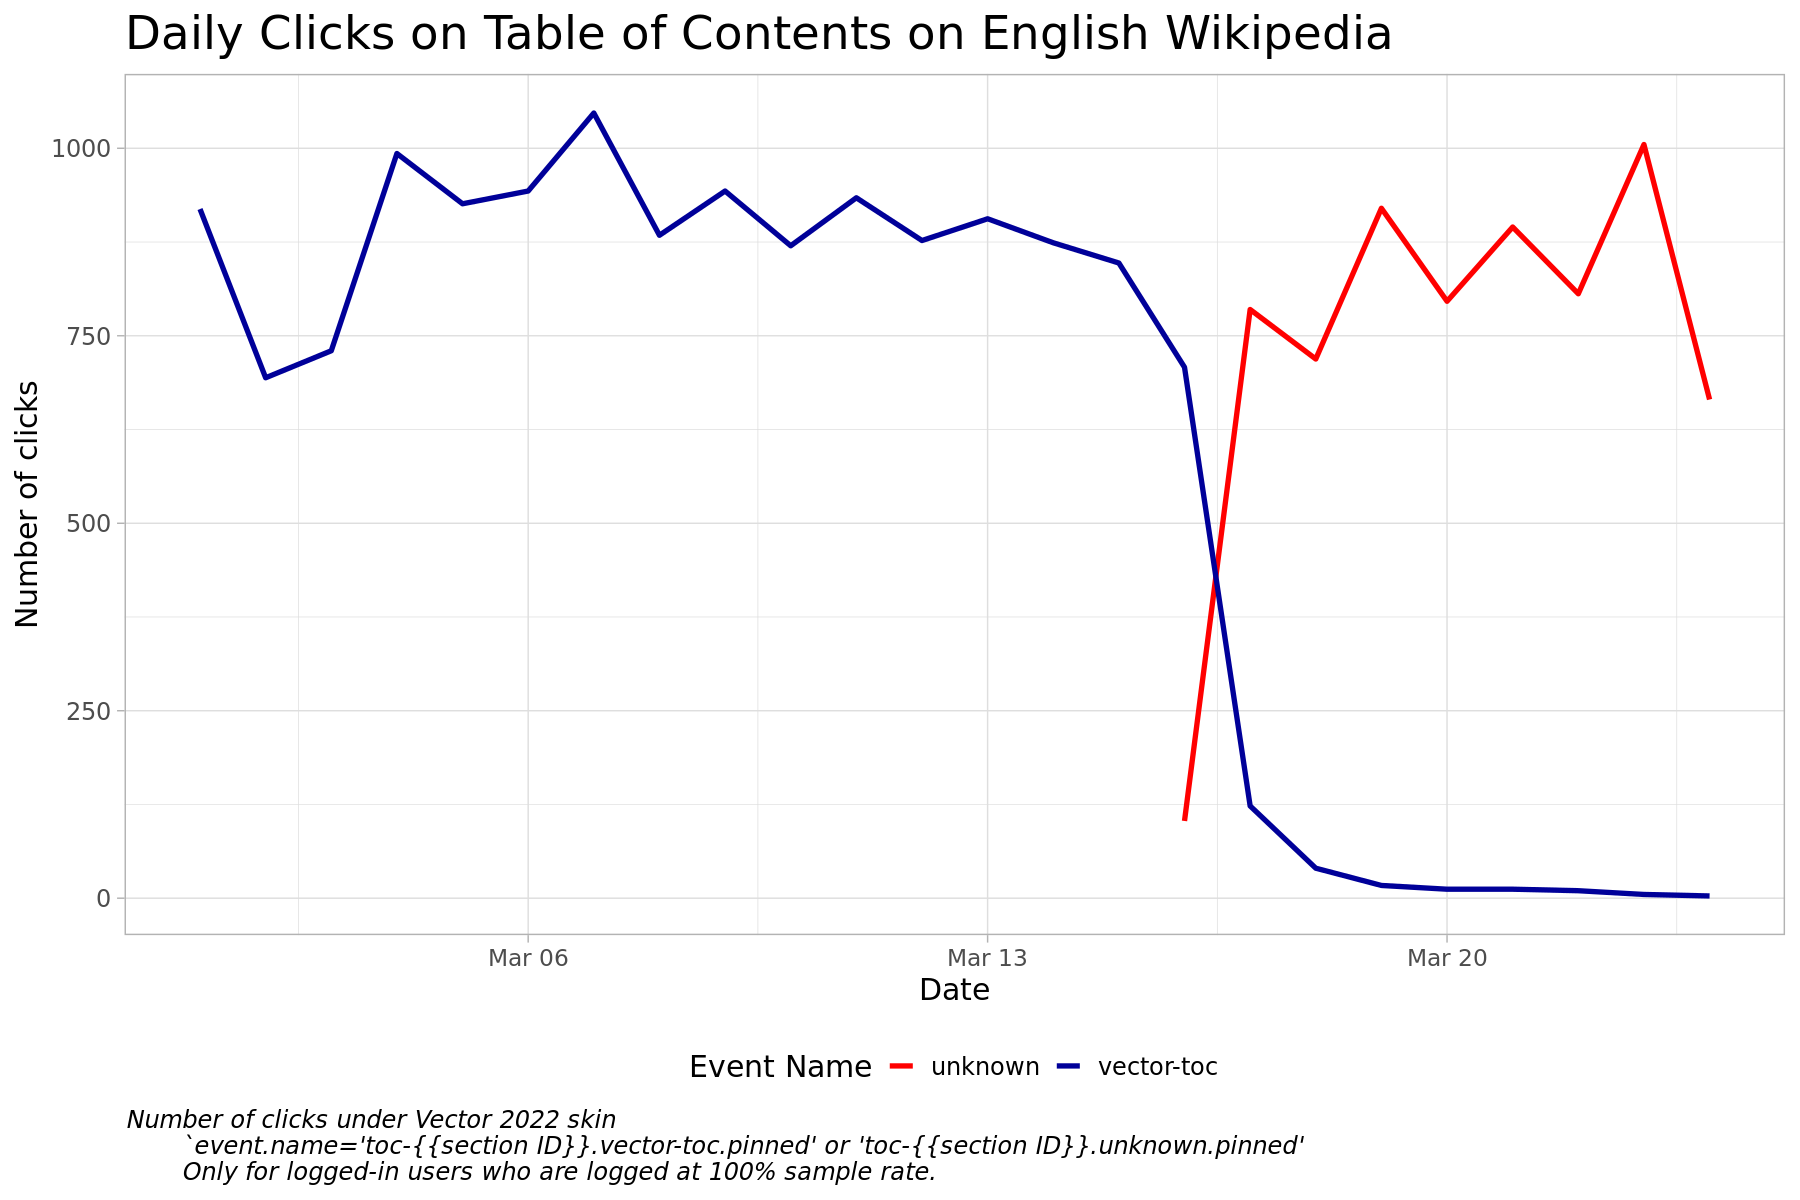

In [80]:
test_g <- df_test  %>%
   ggplot(mapping=aes(x=event_date, y=clicks, color=event_name)) +
   geom_line( size = 1.5) +
  scale_color_manual(values= c("#FF0000", "#000099"), name = "Event Name")  +
  labs(title = 'Daily Clicks on Table of Contents on English Wikipedia',
     x = 'Date',
     y = 'Number of clicks',
     caption = "Number of clicks under Vector 2022 skin
       `event.name='toc-{{section ID}}.vector-toc.pinned' or 'toc-{{section ID}}.unknown.pinned'
       Only for logged-in users who are logged at 100% sample rate.") +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
test_g

## QA `event.name='toc-{{section ID}}.vector-toc.unpinned'` and `event.name='toc-{{section ID}}.unknown.unpinned'

In [21]:
query_test2 <- "
select TO_DATE(dt) AS event_date,
CASE WHEN event.name regexp 'vector-toc' THEN 'vector-toc' 
     WHEN event.name regexp 'unknown' THEN 'unknown' 
     ELSE 'others' END AS event_name,
COUNT(1) AS clicks
FROM event.desktopwebuiactionstracking
WHERE year=2023 and month=3 
AND wiki='enwiki'
AND  ((event.name  regexp  '^toc' 
AND event.name  regexp 'vector-toc\\.unpinned$' ) OR
   (event.name  regexp  '^toc' 
AND event.name  regexp 'unknown\\.unpinned$' ) )
GROUP BY TO_DATE(dt),
CASE WHEN event.name regexp 'vector-toc' THEN 'vector-toc' 
     WHEN event.name regexp 'unknown' THEN 'unknown' 
     ELSE 'others' END 
LIMIT 1000
"

In [22]:
df_test2 <- wmfdata::query_hive(query_test2)

Don't forget to authenticate with Kerberos using kinit



In [24]:
df_test2

event_date,event_name,clicks
<chr>,<chr>,<int>
2023-03-03,vector-toc,35
2023-03-13,vector-toc,235
2023-03-24,unknown,348
2023-03-04,vector-toc,83
2023-03-14,vector-toc,185
2023-03-25,unknown,244
2023-03-05,vector-toc,45
2023-03-16,unknown,26
2023-03-24,vector-toc,1


In [81]:
df_test2 <- read.csv("Data_query/data_out/toc_qa2.csv")

In [82]:
df_test2$event_date <- as.Date(df_test2$event_date)

In [85]:
df_test2 %>%
 arrange(event_date)

event_date,event_name,clicks
<date>,<chr>,<int>
2023-03-01,vector-toc,40
2023-03-02,vector-toc,35
2023-03-03,vector-toc,35
2023-03-04,vector-toc,83
2023-03-05,vector-toc,45
2023-03-06,vector-toc,59
2023-03-07,vector-toc,50
2023-03-08,vector-toc,40
2023-03-09,vector-toc,34


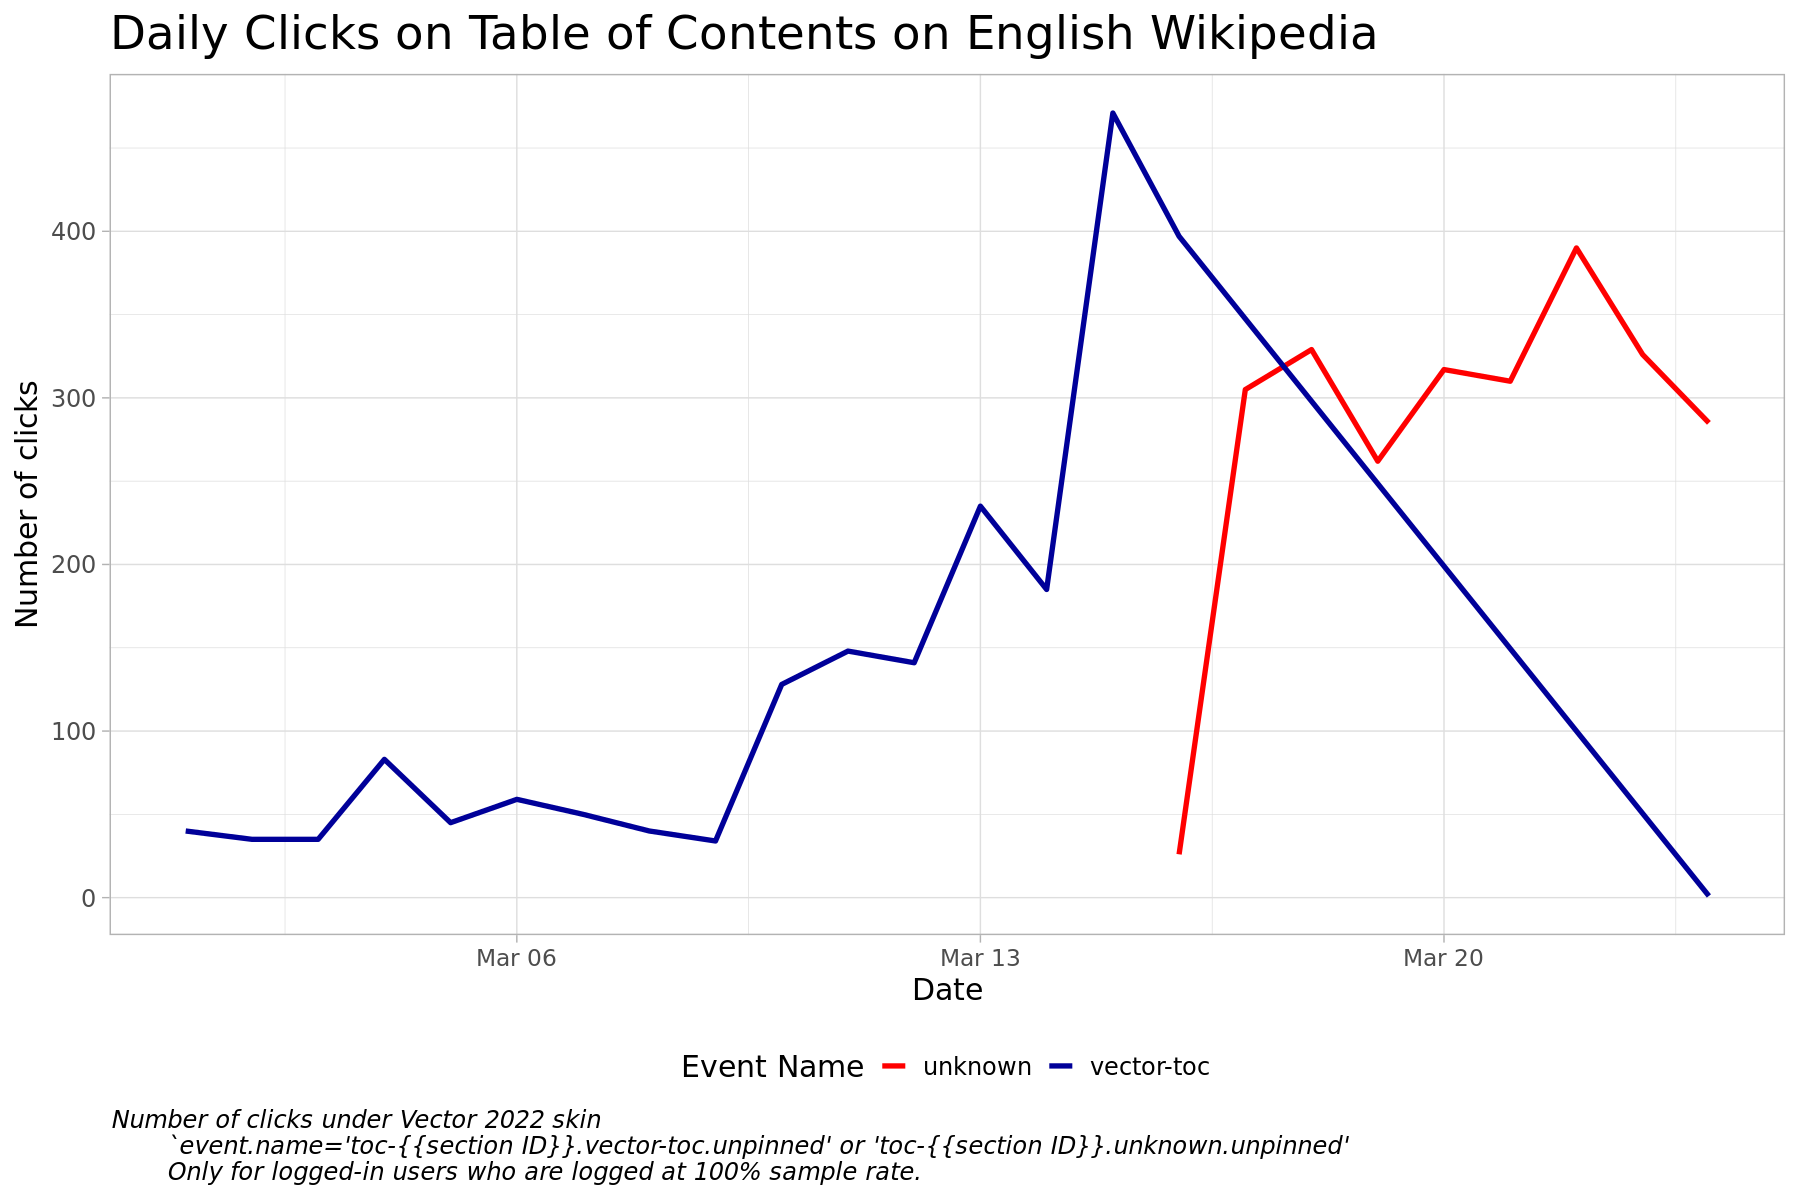

In [83]:
test2_g <- df_test2  %>%
   ggplot(mapping=aes(x=event_date, y=clicks, color=event_name)) +
   geom_line( size = 1.5) +
  scale_color_manual(values= c("#FF0000", "#000099"), name = "Event Name")  +
  labs(title = 'Daily Clicks on Table of Contents on English Wikipedia',
     x = 'Date',
     y = 'Number of clicks',
     caption = "Number of clicks under Vector 2022 skin
       `event.name='toc-{{section ID}}.vector-toc.unpinned' or 'toc-{{section ID}}.unknown.unpinned'
       Only for logged-in users who are logged at 100% sample rate.") +
theme_light(base_size=18) +
theme(legend.position = "bottom", 
     plot.caption = element_text(hjust = 0, face= "italic"),
     strip.text = element_text(size = 18, colour='black'),
     axis.text.x = element_text( size = 14 ),
     plot.title = element_text(size=28))
test2_g

## Summary of data issues

Since 2023-03-16, 
`event.name='toc-{{section ID}}.vector-toc.pinned'` started to be logged as  `event.name='toc-{{section ID}}.unknown.pinned'`.    
`event.name='toc-{{section ID}}.vector-toc.unpinned'` started to be logged as  `event.name='toc-{{section ID}}.unknown.unpinned'`.  

# Dump data

In [29]:
head(df_event_name)

,name
,<chr>
1,"toc-""Precedent"".unknown.unpinned"
2,toc-2019_session.vector-toc.pinned
3,toc-Arrest.unknown.pinned
4,toc-Best-seller:_1930s.vector-toc.pinned
5,toc-Categorization.unknown.pinned
6,toc-Combustion_energy_content.vector-toc.unpinned


In [ ]:
write_csv(df_event_name, 'Data_out/toc_event_name.csv')